# Lab 7: Generative Adversarial Networks (GANs)

In this lab, we will develop several basic GANs and experiment with them.

Here is the basic GAN model described by Goodfellow et al. (2014):

<img src="img/gan_architecture-1.png" title="GAN Framework" style="width: 640px;" />

After this lab, you may be interested in [6 GAN Architectures You Really Should Know](https://neptune.ai/blog/6-gan-architectures).

## Gan Setup

Let's build our first GAN.

There are about a million tutorials on coding GANs with PyTorch available online. We'll use
[code from GitHub user diegoalejogm](https://github.com/diegoalejogm/gans).

To run this code you'll need some dependencies such as tensorboardX:

In [2]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Here is a `Logger` class with a lot of useful tricks to indicate training progress and visualize results.

In [3]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

## Vanilla GAN for MNIST dataset

Next we'll download the MNIST dataset as a small dataset we can get things running on quickly:

In [4]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets

DATA_FOLDER = './torch_data/VGAN/MNIST'
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load Dataset and attach a DataLoader

data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

### Generator

This "vanilla" GAN is the simplest GAN network architecture.

The generator is driven by a noise vector
sampled from a latent space (the domain of $p_z$ and transforms that
noise sample into an element of the domain of
$p_{data}$.

<img src="img/Generator.jpg" title="Generator" style="width: 640px;" />

The generator model in can be practically anything that has the right input
and output tensor shapes. Here is the structure of a simple vanilla GAN generator using only
fully connected layers:

<img src="img/VanillaGAN-Gen.png" title="Generator model" style="width: 640px;" />

And here is sample code for the model's PyTorch Module. Note that since we
normalized the real data to the range [-1,1], to limit the generator to the
same range, we use a tanh activation at the output:

In [5]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

### Discriminator

The discriminator has the responsibity to classify its input as
real or fake. When a fake sample from the generator is given, it should ouptut 0 for fake:

<img src="img/DiscriminatorFake.png" title="Discriminator-1" style="width: 640px;" />

On the other hand, if the input is real, it shoudl output 1 for real:

<img src="img/DiscriminatorReal.jpg" title="Discriminator-2" style="width: 640px;" />

We'll use the following simple discriminator structure:

<img src="img/VanillaGAN-Dis.png" title="VanillaGAN Discriminator" style="width: 640px;" />

Here is the Module:

In [6]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

### Create the modules

Let's create an instance of the generator and discriminator:

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

### Set up the optimizers

The optimization is a min-max game.
The generator wants to minimize the objective function,, whereas the discriminator wants to maximize the same objective function.

<img src="img/GanObjectivefunction.png" title="min-max optimization" style="width: 640px;" />

We know from Goodfellow et al. (2014) that the two networks are trained in an alternating fashion.
So it will be straightforward to have a separate optimizer for each model:


In [8]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 200

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

### Training

The targets for the discriminator may be 0 or 1 depending on whether we're giving it
real or fake data:

In [9]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

Here's a function for a single step for the discriminator:

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

And here's a function for a single step of the generator:

In [11]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

### Generate test noise samples

Let's generate some noise vectors to use as inputs to the generator.
We'll use these samples repeatedly to see the evolution of the generator
over time.

In [14]:
num_test_samples = 16
test_noise = noise(num_test_samples)

## Start training

Now let's train the model:

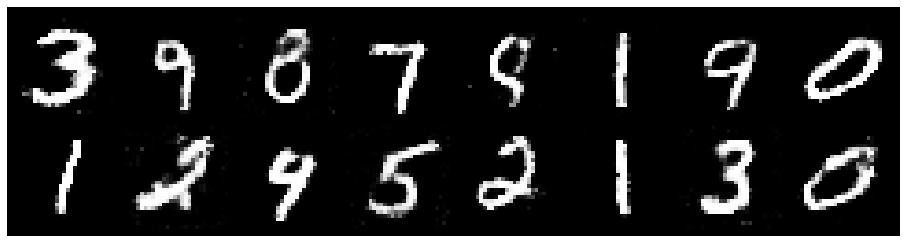

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.3036, Generator Loss: 0.9229
D(x): 0.5416, D(G(z)): 0.4370


In [13]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        
        real_data = images_to_vectors(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

## DCGAN for CIFAR

Our simple generator for MNIST was fully connected. While that worked
fine for MNIST, it would not work for more complex RGB images.

The DCGAN is a GAN with a generator
designed to do just that, generate larger RGB images using convolutional layers.

Here is the DCGAN architecture:

<img src="img/dcgan.png" title="DCGAN" style="width: 1080px;" />

### Load CIFAR10 data

For our DCGAN experiment, we'll use CIFAR rather than MNIST:

In [16]:
DATA_FOLDER = './torch_data/DCGAN/CIFAR'

def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

Files already downloaded and verified


### Networks

Here's another simpler picture of the DCGAN model structures:

<img src="img/dcgan2.png" title="DCGAN" style="width: 640px;" />

Here are PyTorch Modules for them:

In [17]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

The generator is using transpose convolutions with batch normalization:

In [18]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)


Let's create a generator and discriminator and initialize their weights: 

In [19]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

### Optimizers

Next, we set up the optimizers and loss function.

In [20]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 30

### Training

As before, we'll generate a fixed set of noise samples to see the evolution of the
generator over time then start training:

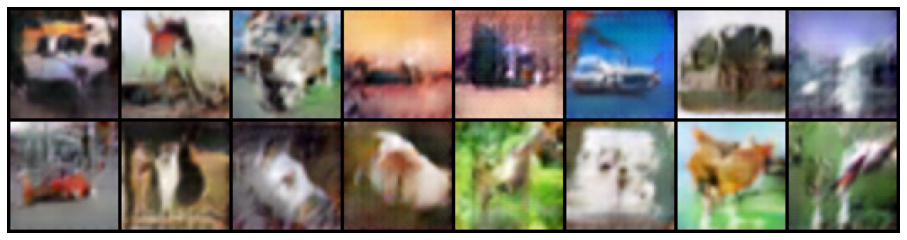

Epoch: [26/30], Batch Num: [300/500]
Discriminator Loss: 0.5868, Generator Loss: 2.1253
D(x): 0.6122, D(G(z)): 0.0413


In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

logger = Logger(model_name='DCGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(data_loader):

        # Train Discriminator
        
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Log error and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)


## Exercises

Do the following on your own:
1. Reproduce the vanilla GAN and DCGAN results on MNIST and CIFAR. Get the training and test loss for the generator and discriminator over time, plot them, and interpret them.
2. Develop your own GAN to model data generated as follows:
   $$\begin{eqnarray} \theta & \sim & {\cal U}(0,2\pi) \\
                      r      & \sim & {\cal N}(0, 1) \\
                      \mathbf{x} & \leftarrow & \begin{cases} \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta + 10\end{bmatrix} & \frac{1}{2}\pi \le \theta \le \frac{3}{2}\pi \\ \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta - 10\end{bmatrix} & \mathrm{otherwise} \end{cases} \end{eqnarray} $$
   You should create a PyTorch DataSet that generates the 2D data in the `__init__()` method, outputs a sample in the `__getitem__()` method, and returns the
   dataset size in the `__len__()` method. Use the vanilla GAN approach above with an appropriate structure for the generator. Can your GAN generate a convincing
   facsimile of a set of samples from the actual distribution?
3. Use the DCGAN (or an improvement to it) to build a generator for a face image set of your choice. Can you get realistic faces that are not in the training set?

As always, submit a brief report documenting your experiments and results.
